In [81]:

"""
월 차트 조회
"""
import pandas as pd

from repository.maria.conn import maria_home

month_chart = pd.read_sql("""
select month_chart.*, stock.name, stock.exchange
from month_chart
join stock on substring(month_chart.code, -6) = stock.code;
""", maria_home())

month_chart["code"] = month_chart["code"].apply(lambda code: code[-6:])
month_chart

,code,date,open,high,low,close,vol,vol_lastday,cap,name,exchange
0,010640,1996-01-31,426,571,426,540,8578133,402317,142928000000,진양폴리,KOSPI
1,000325,1996-01-31,615,624,520,594,143596,67591,724000000,노루홀딩스우,KOSPI
2,003060,1996-01-31,159638,218635,146624,217767,2756,950,3484000000,에이프로젠제약,KOSPI
3,006280,1996-01-31,51233,64561,45401,64561,165110,13367,37122000000,녹십자,KOSPI
4,012330,1996-01-31,8449,9277,8007,8394,774650,26275,350054000000,현대모비스,KOSPI
...,...,...,...,...,...,...,...,...,...,...,...
470824,005710,2022-12-02,5740,5820,5710,5780,17084,5917,115813000000,대원산업,KOSDAQ
470825,062970,2022-12-02,3010,3080,2915,3000,54040,26654,27924000000,피피아이,KOSDAQ
470826,290550,2022-12-02,8860,9190,8810,8840,48733,15270,145524000000,디케이티,KOSDAQ
470827,009415,2022-12-02,9350,10350,7900,7900,167222,35788,10285000000,태영건설우,KOSPI


In [82]:
"""
"""
import pandas as pd
import repository.deepsearch as ds
from base.time import Quarter, YearMonth
from base import rate
import sqlite3

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(".cache/cache.db"))
except Exception as e:
    begin = YearMonth(2002, 4)
    end = YearMonth(2022, 11)

    month_chart["년월"] = [YearMonth.of(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.iter(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        # 당일 1000만원 이상 거래 발생 종목만 취급
        df1 = df1[df1["cap"] != 0]
        df1 = df1[df1["vol"] * df1["close"] > 1_000_0000]
        df1 = df1[df1["vol_lastday"] * df1["close"] > 1_000_0000]
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
            "확정실적": str(Quarter.last_confirmed(ym1.year, ym1.month)),
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1
        #
        df["자산"] = ds.load_one("자산", ym1.year, ym1.month)
        df["자본"] = ds.load_one("자본", ym1.year, ym1.month)
        #
        df["매출총이익"] = ds.load_and("매출총이익", ym1.year, ym1.month, 4, sum)
        df["GP_YoY"] = rate(ds.load_and("매출총이익", ym1.year - 1, ym1.month, 4, sum),
                            ds.load_and("매출총이익", ym1.year, ym1.month, 4, sum))
        df["GP_QoQ"] = rate(ds.load_one("매출총이익", ym1.year - 1, ym1.month), ds.load_one("매출총이익", ym1.year, ym1.month))
        #
        df["영업이익"] = ds.load_and("영업이익", ym1.year, ym1.month, 4, sum)
        df["O_YoY"] = rate(ds.load_and("영업이익", ym1.year - 1, ym1.month, 4, sum),
                           ds.load_and("영업이익", ym1.year, ym1.month, 4, sum))
        df["O_QoQ"] = rate(ds.load_one("영업이익", ym1.year - 1, ym1.month), ds.load_one("영업이익", ym1.year, ym1.month))
        #
        df["당기순이익"] = ds.load_and("당기순이익", ym1.year, ym1.month, 4, sum)
        #
        df["영업활동으로인한현금흐름"] = ds.load_and("영업활동으로인한현금흐름", ym1.year, ym1.month, 4, sum)
        df["CF_YoY"] = rate(ds.load_and("영업활동으로인한현금흐름", ym1.year - 1, ym1.month, 4, sum),
                            ds.load_and("영업활동으로인한현금흐름", ym1.year, ym1.month, 4, sum))
        df["CF_QoQ"] = rate(ds.load_one("영업활동으로인한현금흐름", ym1.year - 1, ym1.month),
                            ds.load_one("영업활동으로인한현금흐름", ym1.year, ym1.month))
        #
        layer1 = pd.concat([layer1, df])

layer1 = layer1.reset_index()
layer1

,index,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,...,매출총이익,GP_YoY,GP_QoQ,O_YoY,O_QoQ,영업이익,당기순이익,영업활동으로인한현금흐름,CF_YoY,CF_QoQ
0,0,011785,금호석유우,KOSPI,2002-04,2002-05,9177000000,2002-04-30,1920,1108870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,042500,링네트,KOSDAQ,2002-04,2002-05,17857000000,2002-04-30,1500,6357458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,001740,SK네트웍스,KOSPI,2002-04,2002-05,663658000000,2002-04-30,240282,333190,...,1.186211e+12,0.589507,0.539648,-0.445409,-1.493706,1.457976e+11,-1.177615e+11,NaN,NaN,NaN
3,3,012320,경동인베스트,KOSPI,2002-04,2002-05,47832000000,2002-04-30,14403,342655,...,4.909685e+10,-0.006955,-0.026227,-0.213679,0.328122,1.499016e+10,1.501754e+10,NaN,NaN,NaN
4,4,004415,서울식품우,KOSPI,2002-04,2002-05,1016000000,2002-04-30,226,3775781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376488,376488,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,1045856,...,5.696930e+10,0.732314,0.575744,-1.506782,-0.653779,4.649376e+09,1.066560e+08,-2.682557e+10,-1.620735,-0.744776
376489,376489,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2695887,...,2.460088e+10,0.281257,0.013266,2.083479,0.180116,8.088178e+09,9.213221e+09,4.756499e+09,-0.497742,-1.599327
376490,376490,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,192218,...,6.507321e+10,0.041626,0.052843,0.020614,0.377019,3.600380e+10,6.162755e+10,4.401215e+10,0.239903,0.402507
376491,376491,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,479928,...,-1.490204e+09,-0.783547,-1.462374,-0.575632,-1.151010,-4.446674e+09,-8.292667e+09,-2.244381e+09,-0.612744,-0.842224


In [83]:
# layer1.to_sql("layer1", sqlite3.connect(".cache/cache.db"), if_exists="replace", index=False)

In [99]:

import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "자산": "A",
        "자본": "EQ",

        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
        "영업활동으로인한현금흐름": "CF"
    }
)

factors = ["GP_YoY", "GP_QoQ", "O_YoY", "O_QoQ", "CF_YoY", "CF_QoQ"]

for pos in ["A", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["P", "A", "EQ"]:
    for pos in ["GP", "O", "E", "CF"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("1/P")
layer2["1/P"] = 1 / layer2["P"]

result = pd.DataFrame()
yms = layer2["매수년월"].unique()
rank_scale = 100

sfw = pd.read_sql("select * from sfw", sqlite3.connect(".cache/cache.db")).set_index("factor")
sfw = sfw.drop(index="super")
# spearman 상관계수가 -0.3 보다 작아야 함
sfw = sfw[sfw["spearman"] < -0.3]
# head5 mean보다 커야함
sfw = sfw[sfw["h5"] > sfw["mean"]]
# head5가 median보다 커야함
sfw = sfw[sfw["h5"] > sfw["median"]]

for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_rank = f"{factor}_rank"
        df[colname_rank] = np.ceil(df[factor].rank(ascending=False, method="min", pct=True) * rank_scale)
        df[f"{factor}_power"] = (df[factor] - df[factor].mean()) / df[factor].std()

        if df[colname_rank].count() > len(df) / 2:
            # 절반 이상 na 아닐 경우에만 수행
            df[colname_rank] = df[colname_rank].fillna(round(df[colname_rank].dropna().median()))
            assert df[colname_rank].min() == 1, df[colname_rank]
            assert df[colname_rank].max() == rank_scale


    ###########################################################################
    def calc_super(_factor_name, _factor_analysis: pd.Series):
        # -sfw["spearman"] 이거를 1-sfw["spearman"]로 변경해볼수도?
        _result = df[f"{_factor_name}_power"] * pow(-(_factor_analysis["spearman"]) * _factor_analysis["h5"], 2)
        if _result.count() > len(_result) / 2:
            _result = _result.fillna(_result.median())
        else:
            _result.loc[:] = 0
        return _result


    df["super"] = sum([calc_super(*sfw_item) for sfw_item in sfw.iterrows()])
    df["super_power"] = (df["super"] - df["super"].mean()) / df["super"].std()
    df["super_rank"] = np.ceil(df["super"].rank(ascending=False, method="min", pct=True) * rank_scale)

    if df["super_rank"].count() > len(df) / 2:
        # 절반 이상 na 아닐 경우에만 수행
        df["super_rank"] = df["super_rank"].fillna(round(df["super_rank"].dropna().median()))
        assert df["super_rank"].min() == 1, df["super_rank"]
        assert df["super_rank"].max() == rank_scale

    result = pd.concat([result, df])

factors = ["super"] + factors
result

2022-10

,index,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,...,O/EQ_power,E/EQ_rank,E/EQ_power,CF/EQ_rank,CF/EQ_power,1/P_rank,1/P_power,super,super_power,super_rank
0,0,011785,금호석유우,KOSPI,2002-04,2002-05,9177000000,2002-04-30,1920,1108870,...,NaN,50.0,NaN,NaN,NaN,10.0,0.359623,0.003917,0.048506,25.0
1,1,042500,링네트,KOSDAQ,2002-04,2002-05,17857000000,2002-04-30,1500,6357458,...,NaN,50.0,NaN,NaN,NaN,28.0,-0.034788,-0.058737,-0.179150,43.0
2,2,001740,SK네트웍스,KOSPI,2002-04,2002-05,663658000000,2002-04-30,240282,333190,...,-0.023956,83.0,-0.014487,NaN,NaN,95.0,-0.440562,0.069620,0.287241,15.0
3,3,012320,경동인베스트,KOSPI,2002-04,2002-05,47832000000,2002-04-30,14403,342655,...,0.035085,23.0,0.086319,NaN,NaN,63.0,-0.296107,-0.020576,-0.040489,30.0
4,4,004415,서울식품우,KOSPI,2002-04,2002-05,1016000000,2002-04-30,226,3775781,...,NaN,50.0,NaN,NaN,NaN,1.0,6.877219,1.039269,3.810501,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376488,376488,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,1045856,...,-0.085594,71.0,-0.022173,87.0,-0.588385,56.0,-0.244183,-0.084438,-0.323197,57.0
376489,376489,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2695887,...,0.465880,14.0,0.591787,37.0,0.175564,51.0,-0.206601,-0.142021,-0.563503,76.0
376490,376490,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,192218,...,0.188803,18.0,0.514543,31.0,0.236078,47.0,-0.173919,0.271647,1.162811,9.0
376491,376491,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,479928,...,-4.902997,100.0,-7.184001,99.0,-1.869618,5.0,0.923175,-0.095563,-0.369624,60.0


22/22

,spearman,top,h5,t5,h5-t5,h5-t5+mdd5,mean,median,mdd5
factor,,,,,,,,,
super,-0.957492,0.598398,0.429593,-0.079197,0.508790,0.001056,0.144762,0.135352,-0.507734
GP_YoY,-0.455050,0.088972,0.137559,0.101748,0.035812,-0.594878,0.144517,0.145980,-0.630690
GP_QoQ,-0.738818,0.199279,0.194688,0.088077,0.106611,-0.458959,0.141678,0.138986,-0.565571
O_YoY,-0.001788,0.225137,0.156103,0.180498,-0.024395,-0.631213,0.144595,0.138819,-0.606817
O_QoQ,-0.396568,0.226805,0.217046,0.176929,0.040117,-0.548946,0.140426,0.137152,-0.589063
CF_YoY,0.135290,0.161851,0.170351,0.171087,-0.000737,-0.589335,0.154654,0.156243,-0.588598
CF_QoQ,-0.075932,0.225152,0.164109,0.181410,-0.017301,-0.645725,0.155690,0.155096,-0.628425
A/P,-0.913267,0.238737,0.240821,-0.059219,0.300041,-0.238911,0.139236,0.154111,-0.538952
EQ/P,-0.920924,0.467651,0.317178,-0.063480,0.380658,-0.121302,0.140836,0.154938,-0.501960


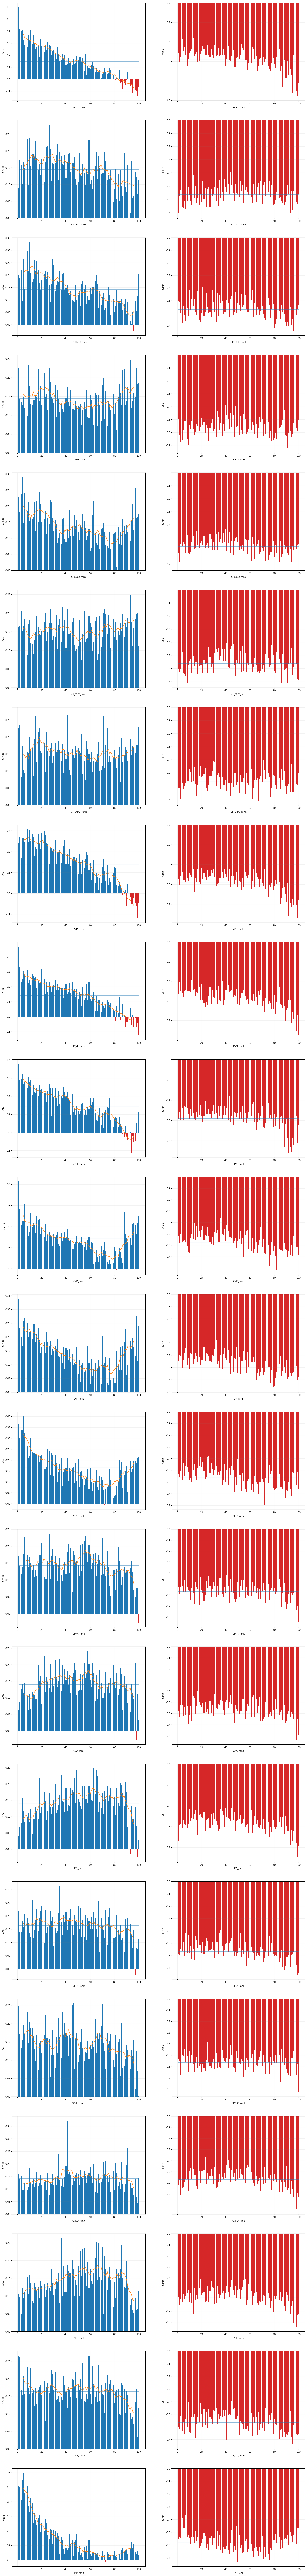

In [100]:
import matplotlib.pyplot as plt
from base import cagr, mdd
from base.time import YearMonth
from datetime import date

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10000

fig, subplots = plt.subplots(len(factors), 2)
fig.set_figwidth(20), fig.set_figheight(8 * len(factors))

summary = pd.DataFrame()
for i in range(len(factors)):
    print(f"\r{i + 1}/{len(factors)}", end="")

    factor = factors[i]

    colname_rank = f"{factor}_rank"
    rank = sorted(set(result[colname_rank].dropna()))
    mean_by_rank = []
    cagr_by_rank = []
    mdd_by_rank = []
    for r in rank:
        rankers = result[result[colname_rank] == r]
        return_by_ym = rankers.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(rankers["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_rank.append(return_by_ym.mean())
        cagr_by_rank.append(cagr(1, last, rankers["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_rank.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_rank_series = pd.Series(cagr_by_rank)
    mdd_by_rank_series = pd.Series(mdd_by_rank)

    ax1.set_xlabel(colname_rank)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(rank, cagr_by_rank, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_rank])
    ax1.plot(rank, [cagr_by_rank_series.mean() for _ in rank], alpha=0.5)
    ax1.plot(rank, cagr_by_rank_series.rolling(9, center=True).mean())

    ax2.set_xlabel(colname_rank)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(rank, mdd_by_rank, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_rank])
    ax2.plot(rank, [mdd_by_rank_series.mean() for _ in rank], alpha=0.5)

    # ax3.set_xlabel(f"{factor}_power")
    # ax3.set_ylabel("Return")
    # ax3.grid(True)
    # # ax3.scatter(result[f"{factor}_power"], result["수익률"], alpha=0.5)
    # x = result[f"{factor}_power"]
    # y = result["수익률"]
    # x = x[x.notna() & y.notna()].sort_values()
    # y = y[x.notna() & y.notna()]
    # z = np.polyfit(x, y, 1)
    # p = np.poly1d(z)
    # ax3.plot(x, p(x))

    corr = pd.DataFrame({colname_rank: rank, "cagr": cagr_by_rank}).corr(method="spearman")
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_rank]["cagr"],
            "top": cagr_by_rank_series.head(1).mean(),
            "h5": cagr_by_rank_series.head(5).mean(),
            "t5": cagr_by_rank_series.tail(5).mean(),
            "h5-t5": cagr_by_rank_series.head(5).mean() - cagr_by_rank_series.tail(5).mean(),
            "h5-t5+mdd5": cagr_by_rank_series.head(5).mean() - cagr_by_rank_series.tail(
                5).mean() + mdd_by_rank_series.head(5).mean(),
            "mean": cagr_by_rank_series.mean(),
            "median": cagr_by_rank_series.median(),
            "mdd5": mdd_by_rank_series.head(5).mean(),
        }).to_frame(factor).T
    ])

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(".cache/cache.db"), if_exists="replace")
summary

In [94]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "super"
head = 20
result2 = result[result["종목명"].str.endswith("홀딩스") == False]
strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor).tail(head)["수익률"].mean())
result2.groupby(_key).apply(lambda values: values.sort_values(factor).tail(head))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가"]]

code    종목명       수익률    거래소         매수일  \
매수년월    매도년월                                                         
2002-04 2002-05 139     003960   사조대림  0.060615  KOSPI  2002-04-30   
                384     025890   한국주강  0.179012  KOSPI  2002-04-30   
                912     003520   영진약품  0.049320  KOSPI  2002-04-30   
                4       004415  서울식품우  0.004425  KOSPI  2002-04-30   
                805     007575  일양약품우 -0.037830  KOSPI  2002-04-30   
...                        ...    ...       ...    ...         ...   
2022-10 2022-11 374432  007860     서연  0.563218  KOSPI  2022-10-31   
                375765  267810     앙츠 -0.036145  KONEX  2022-10-31   
                374233  001040     CJ  0.068245  KOSPI  2022-10-31   
                374603  329020   오션스톤 -0.100000  KONEX  2022-10-31   
                374157  000880     한화  0.143701  KOSPI  2022-10-31   

                               매도일    매수가      매도가  
매수년월    매도년월                                        
2002-04 2002-05 139     2002-05-31  38621  40962.0  
                384     2002-05-31    162    191.0  
                912     2002-05-31   1764   1851.0  
                4       2002-05-31    226    227.0  
                805     2002-05-31   2009   1933.0  
...                            ...    ...      ...  
2022-10 2022-11 374432  2022-11-30   5220   8160.0  
                375765  2022-11-30   1245   1200.0  
                374233  2022-11-30  71800  76700.0  
                374603  2022-11-30   2000   1800.0  
                374157  2022-11-30  25400  29050.0  

[4940 rows x 8 columns]

In [87]:
from base import cagr, mdd
from base.time import YearMonth

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

revisions

          CAGR                                        MDD      Mean
전략    0.558310  (-0.5383063646615694, (2007-09, 2008-10))  0.043579
벤치마크  0.151884  (-0.5373814900711391, (2007-07, 2008-10))  0.014212


,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2002-04,2002-05,-0.045802,0.012948,0.06,0.954198,1.012948
2002-05,2002-06,-0.104989,-0.108543,-0.00,0.854018,0.903000
2002-06,2002-07,-0.002524,0.026035,0.03,0.851862,0.926510
2002-07,2002-08,0.034868,0.063768,0.03,0.881565,0.985592
2002-08,2002-09,-0.149046,-0.053112,0.10,0.750171,0.933246
...,...,...,...,...,...,...
2022-06,2022-07,0.064967,0.009703,-0.06,19.508014,8248.490458
2022-07,2022-08,0.007675,0.001613,-0.01,19.657745,8261.795194
2022-08,2022-09,-0.153449,0.014811,0.17,16.641287,8384.160134


전체 개월 수      247.00
초과수익 개월 수    132.00
아웃퍼폼 총합       10.45
언더퍼폼 총합       -3.19
dtype: float64

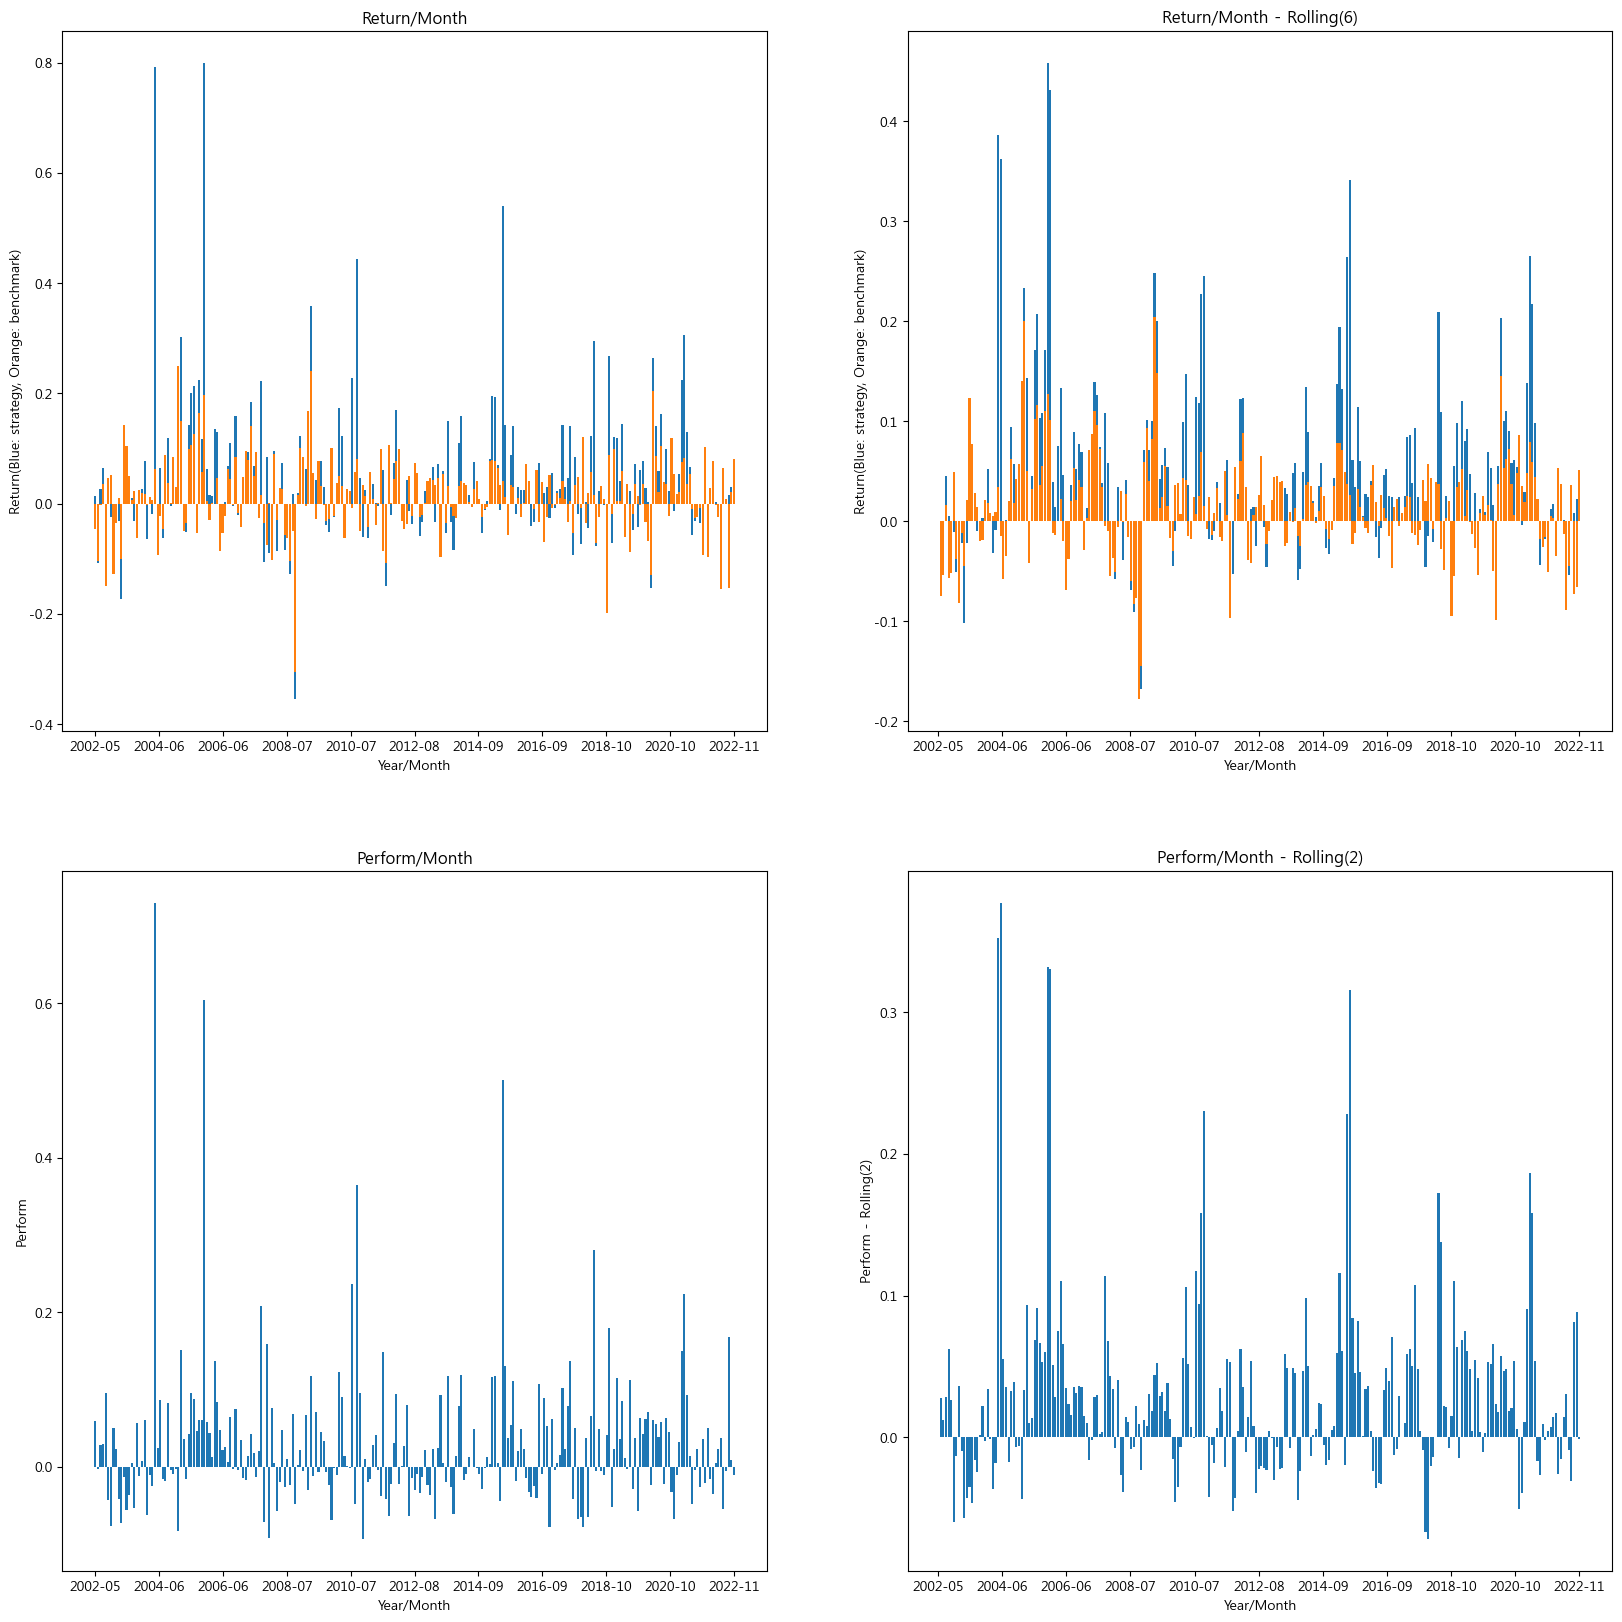

In [88]:
import numpy as np
import matplotlib.pyplot as plt

rank = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

x_label = "Year/Month"
y_label = "Return(Blue: strategy, Orange: benchmark)"
ax1.set_title(f"Return/Month")
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))

ax1.bar(rank, revisions["전략 수익률"])
ax1.bar(rank, revisions["벤치마크 수익률"])

window = 2
ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month"), ax2.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(rank, revisions["전략 수익률"].rolling(window).mean())
ax2.bar(rank, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title("Perform/Month")
ax3.set_xlabel("Year/Month"), ax3.set_ylabel("Perform")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(rank, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax4.set_title(f"Perform/Month - Rolling({window})")
ax4.set_xlabel("Year/Month"), ax4.set_ylabel(f"Perform - Rolling({window})")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(rank, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "아웃퍼폼 총합": revisions[revisions["성능"] > 0]["성능"].sum(),
    "언더퍼폼 총합": revisions[revisions["성능"] < 0]["성능"].sum()
})